In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import HeteroConv, SAGEConv, RGCNConv, Linear
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

In [46]:
from owlready2 import get_ontology
import pandas as pd

# Step 1: Load the ontology
ontology = get_ontology("enriched_ppio_ontology_final_54_small.owl").load()

# Step 2: Extract triples (filter for specific relationships)
def extract_triples(ontology, relations_of_interest):
    """
    Extract triples (head, relation, tail) from ontology, focusing on specific relationships.
    """
    triples = []
    for entity in ontology.individuals():  # Iterate through individuals
        for prop in entity.get_properties():  # Iterate through properties
            if prop.python_name in relations_of_interest:
                for value in prop[entity]:
                    if hasattr(value, 'name'):  # Check if value is another ontology entity
                        triples.append((entity.name, prop.python_name, value.name))
    return triples

# Define the relationships to focus on
relations_of_interest = ["hasSample", "isAssociatedWithPathway","hasGeneExpression"]

# Extract relevant triples
triples = extract_triples(ontology, relations_of_interest)
triples_df = pd.DataFrame(triples, columns=["head", "relation", "tail"])

print(triples_df.head())


                head           relation               tail
0       Patient_HC_1          hasSample  Sample_GSM1317896
1       Patient_HC_1          hasSample  Sample_GSM1318041
2  Sample_GSM1317896  hasGeneExpression         Gene_60496
3  Sample_GSM1317896  hasGeneExpression            Gene_18
4  Sample_GSM1317896  hasGeneExpression         Gene_10347


In [47]:
triples_array = triples_df.to_numpy()

# Create Train-Test-Validation splits
train_triples, test_triples, valid_triples = np.split(
    triples_array,
    [int(0.7 * len(triples_array)), int(0.85 * len(triples_array))],  # 70% train, 15% validation, 15% test
)

# Create TriplesFactory for each split
training_factory = TriplesFactory.from_labeled_triples(train_triples)
validation_factory = TriplesFactory.from_labeled_triples(valid_triples)
testing_factory = TriplesFactory.from_labeled_triples(test_triples)


Clustering: Use relationships like isAssociatedWithPathway, hasCoExpressionWith, and hasPhysicalInteractionWith to cluster entities based on their functional or interaction profiles

In [48]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from pykeen.pipeline import pipeline

# Train TransE model
transe_result = pipeline(
    model='TransE',
    training=training_factory,
    validation=validation_factory,
    testing=testing_factory,
    epochs=10,
    dimensions=128,
    random_seed=42,
)

# Train ComplEx model
complex_result = pipeline(
    model='ComplEx',
    training=training_factory,
    validation=validation_factory,
    testing=testing_factory,
    epochs=10,
    dimensions=128,
    random_seed=42,
)

# Train RotatE model
rotate_result = pipeline(
    model='RotatE',
    training=training_factory,
    validation=validation_factory,
    testing=testing_factory,
    epochs=10,
    dimensions=128,
    random_seed=42,
)

# Extract embeddings from models
transE_embeddings = transe_result.model.entity_representations[0]().detach().cpu().numpy()
complEx_embeddings = np.concatenate(
    [complex_result.model.entity_representations[0]().real.detach().cpu().numpy(),
     complex_result.model.entity_representations[0]().imag.detach().cpu().numpy()],
    axis=1
)
rotate_embeddings = rotate_result.model.entity_representations[0]().detach().cpu().numpy()


INFO:pykeen.pipeline.api:Using device: None
Training batches on cpu:  92%|███████████████████▍ | 605/655 [00:00<00:00, 1037.81batch/s]
Training epochs on cpu:  20%|▏| 2/10 [00:04<00:17,  2.16s/epoch, loss=0.416, prev_loss=0.6
Training batches on cpu:  99%|████████████████████▋| 646/655 [00:00<00:00, 1051.68batch/s]
Training epochs on cpu:  30%|▎| 3/10 [00:06<00:14,  2.11s/epoch, loss=0.404, prev_loss=0.4
Training batches on cpu:  97%|█████████████████████▎| 634/655 [00:00<00:00, 988.08batch/s]
Training epochs on cpu:  40%|▍| 4/10 [00:08<00:12,  2.12s/epoch, loss=0.4, prev_loss=0.404
Training batches on cpu:  96%|████████████████████ | 626/655 [00:00<00:00, 1054.49batch/s]
Training epochs on cpu:  50%|▌| 5/10 [00:10<00:10,  2.09s/epoch, loss=0.397, prev_loss=0.4
Training batches on cpu:  96%|████████████████████▏| 631/655 [00:00<00:00, 1060.68batch/s]
Training epochs on cpu:  60%|▌| 6/10 [00:12<00:08,  2.08s/epoch, loss=0.393, prev_loss=0.3
Training batches on cpu:  94%|████████████████

In [50]:
# Convert RotatE complex embeddings to real-valued embeddings
rotate_real_embeddings = np.concatenate(
    [rotate_embeddings.real, rotate_embeddings.imag], axis=1
)


In [51]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

# Prepare the graph data
# Define entity IDs
entities = {entity: idx for idx, entity in enumerate(training_factory.entity_to_id.keys())}

# Convert triples into edges for PyTorch Geometric
edge_index = torch.tensor([
    [entities[head], entities[tail]]
    for head, _, tail in training_factory.triples
]).t().contiguous()

# Create a graph
num_nodes = len(entities)
x = torch.randn(num_nodes, 128)  # Random initialization of node features
data = Data(x=x, edge_index=edge_index)

# Define GCN Model
class GCNModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Train GCN
gcn_model = GCNModel(input_dim=128, hidden_dim=64, output_dim=128)
optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.01)
for epoch in range(50):
    optimizer.zero_grad()
    embeddings = gcn_model(data)
    loss = torch.nn.MSELoss()(embeddings, data.x)  # Reconstruction loss
    loss.backward()
    optimizer.step()

# Extract GCN embeddings
gcn_embeddings = embeddings.detach().cpu().numpy()


TransE Clustering Metrics:
Silhouette Score: 0.0235
Davies-Bouldin Index: 5.3569
Calinski-Harabasz Index: 52.1089



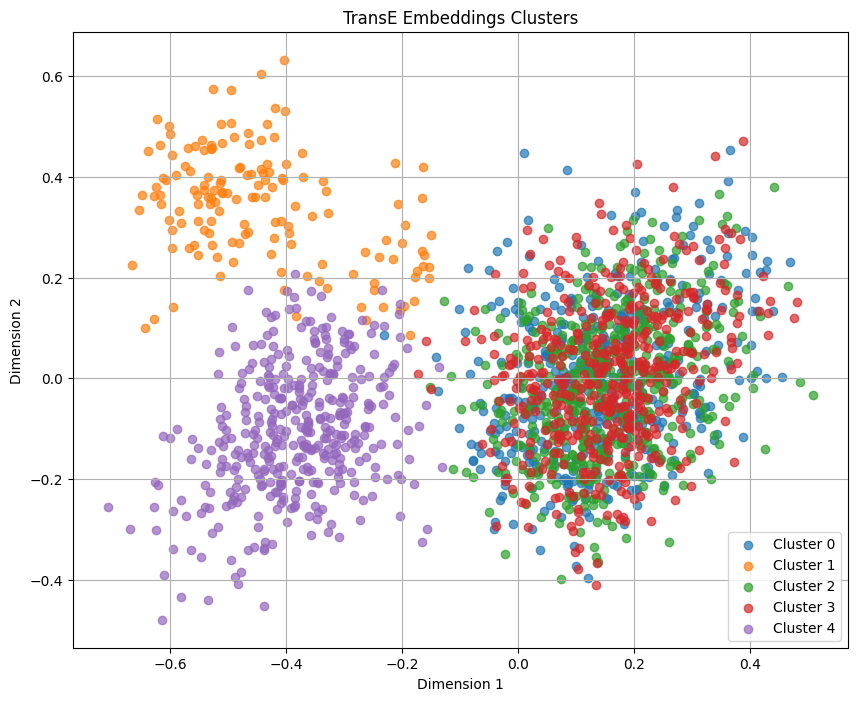

ComplEx Clustering Metrics:
Silhouette Score: 0.0001
Davies-Bouldin Index: 12.3672
Calinski-Harabasz Index: 4.1228



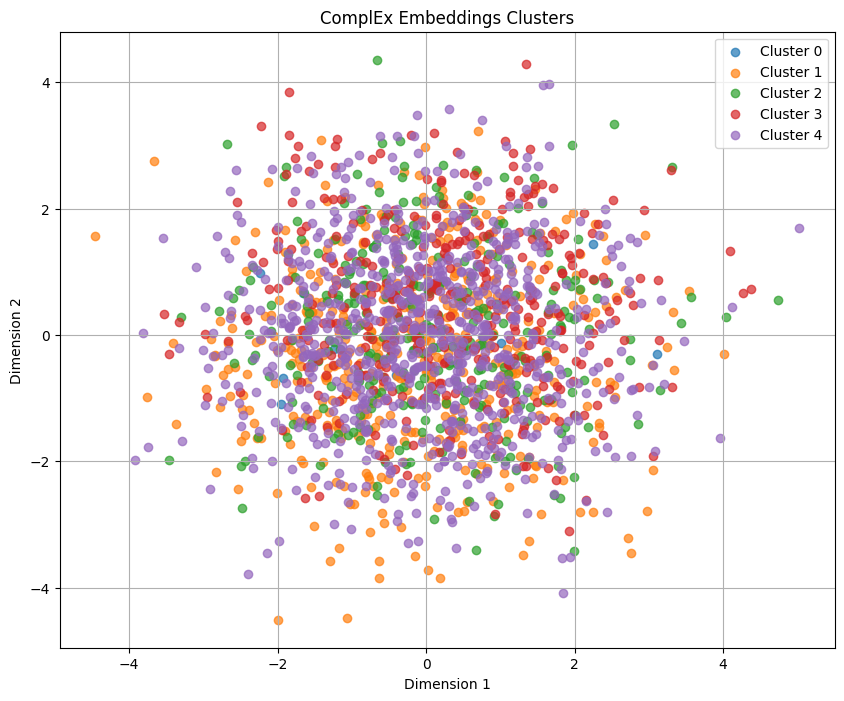

GCN Clustering Metrics:
Silhouette Score: 0.8374
Davies-Bouldin Index: 0.5031
Calinski-Harabasz Index: 546.9454



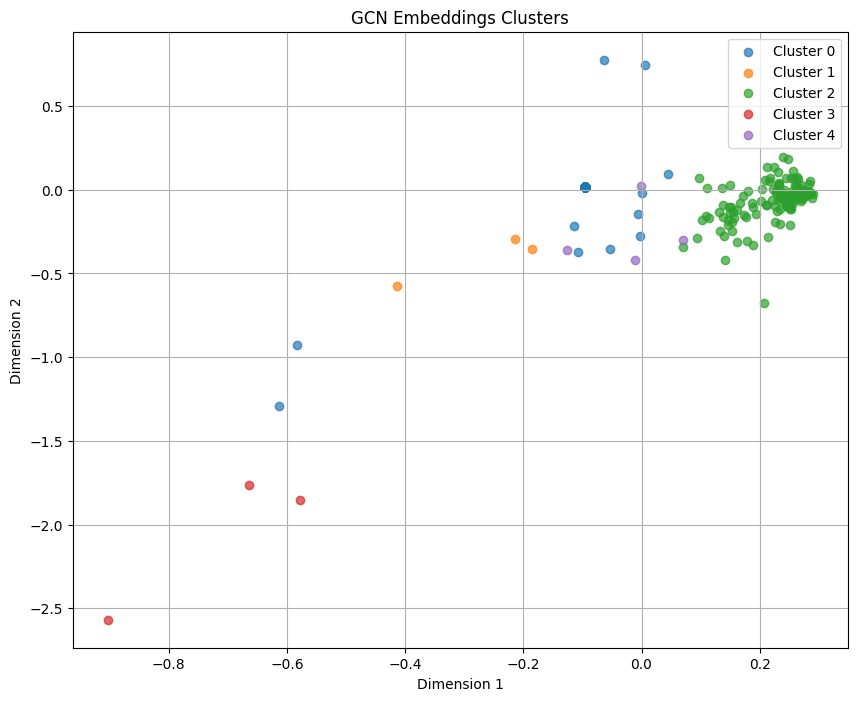

RotatE Clustering Metrics:
Silhouette Score: 0.0434
Davies-Bouldin Index: 3.2702
Calinski-Harabasz Index: 211.2308



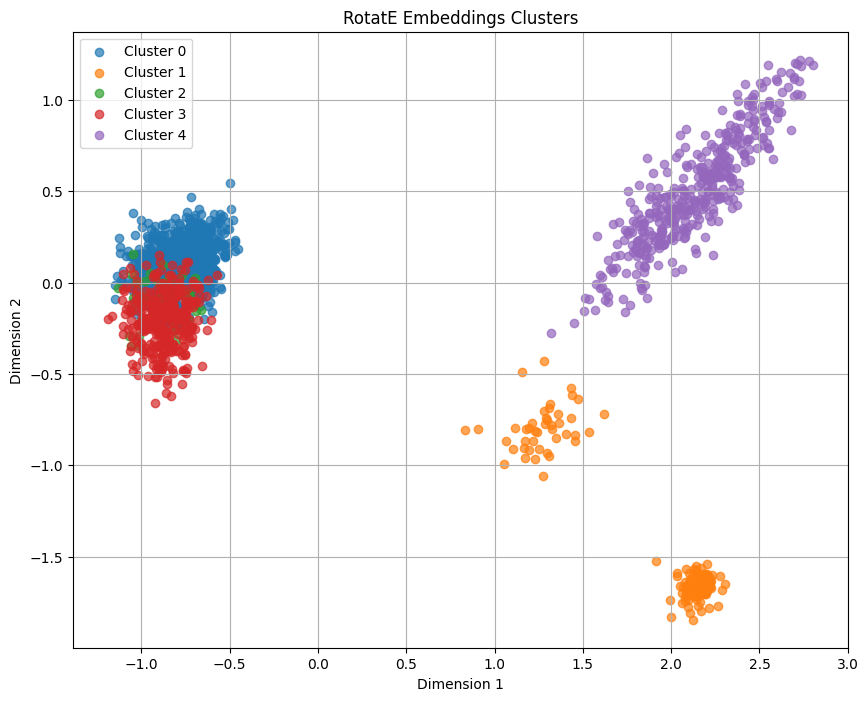

In [54]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

def cluster_and_visualize(embeddings, model_name):
    # Clustering
    kmeans = KMeans(n_clusters=5, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings)

    # Calculate Clustering Metrics
    silhouette = silhouette_score(embeddings, cluster_labels)
    db_index = davies_bouldin_score(embeddings, cluster_labels)
    ch_index = calinski_harabasz_score(embeddings, cluster_labels)

    print(f"{model_name} Clustering Metrics:")
    print(f"Silhouette Score: {silhouette:.4f}")
    print(f"Davies-Bouldin Index: {db_index:.4f}")
    print(f"Calinski-Harabasz Index: {ch_index:.4f}\n")

    # Dimensionality Reduction (PCA)
    reduced_embeddings = PCA(n_components=2).fit_transform(embeddings)

    # Visualization
    plt.figure(figsize=(10, 8))
    for cluster_id in np.unique(cluster_labels):
        
        cluster_points = reduced_embeddings[cluster_labels == cluster_id]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}", alpha=0.7)
    plt.title(f"{model_name} Embeddings Clusters")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.legend()
    plt.grid()
    plt.show()

# Apply clustering and visualization for each embedding type
cluster_and_visualize(transE_embeddings, "TransE")
cluster_and_visualize(complEx_embeddings, "ComplEx")
cluster_and_visualize(gcn_embeddings, "GCN")
cluster_and_visualize(rotate_real_embeddings, "RotatE")



In [30]:
from owlready2 import get_ontology
import itertools

def process_triples_on_the_fly(ontology, sample_size=3):
    """
    Process triples on-the-fly without loading everything into memory.

    Parameters:
        ontology: The loaded ontology.
        sample_size: Number of samples per relation.
    
    Returns:
        sampled_relations: Dictionary of sampled triples for each relation.
    """
    relations_dict = {}

    for entity in ontology.individuals():  # Iterate through individuals
        for prop in entity.get_properties():  # Iterate through properties
            relation = prop.python_name
            for value in prop[entity]:
                # Check if value is an ontology entity
                triple = (
                    entity.name, 
                    relation, 
                    value.name if hasattr(value, 'name') else str(value)
                )

                # Dynamically sample triples per relation
                if relation not in relations_dict:
                    relations_dict[relation] = []
                if len(relations_dict[relation]) < sample_size:
                    relations_dict[relation].append(triple)

    return relations_dict

# Load ontology
ontology = get_ontology("enriched_ppio_ontology_final_54.owl").load()

# Process triples on-the-fly
sampled_triples = process_triples_on_the_fly(ontology, sample_size=3)

# Display results
for relation, samples in sampled_triples.items():
    print(f"Relation: {relation}")
    for triple in samples:
        print(triple)
    print("-" * 50)


Relation: isAssociatedWith
('Gene_60496', 'isAssociatedWith', 'GO_0005737')
('Gene_60496', 'isAssociatedWith', 'GO_0005515')
('Gene_60496', 'isAssociatedWith', 'GO_0005829')
--------------------------------------------------
Relation: isSourcedFrom
('Gene_60496', 'isSourcedFrom', 'GSE54514')
('Gene_60496', 'isSourcedFrom', 'GSE65682')
('Gene_18', 'isSourcedFrom', 'GSE54514')
--------------------------------------------------
Relation: hasCoExpressionWith
('Gene_60496', 'hasCoExpressionWith', 'Gene_5621')
('Gene_60496', 'hasCoExpressionWith', 'Gene_23451')
('Gene_60496', 'hasCoExpressionWith', 'Gene_114932')
--------------------------------------------------
Relation: isExpressedBy
('Gene_60496', 'isExpressedBy', 'Protein_AASDHPPT')
('Gene_60496', 'isExpressedBy', 'Protein_AASDHPPT')
('Gene_18', 'isExpressedBy', 'Protein_ABAT')
--------------------------------------------------
Relation: isAssociatedWithPathway
('Gene_60496', 'isAssociatedWithPathway', 'Pathway_0000000')
('Gene_60496', 

In [45]:

# Step 2: Extract triples (filter for specific relationships)
def extract_triples(ontology, relations_of_interest):
    """
    Extract triples (head, relation, tail) from ontology, focusing on specific relationships.
    """
    triples = []
    for entity in ontology.individuals():  # Iterate through individuals
        for prop in entity.get_properties():  # Iterate through properties
            if prop.python_name in relations_of_interest:
                for value in prop[entity]:
                    if hasattr(value, 'name'):  # Check if value is another ontology entity
                        triples.append((entity.name, prop.python_name, value.name))
    return triples

# Define the relationships to focus on
relations_of_interest = ["hasCoExpressionWith", "isAssociatedWithPathway","hasPValue"]

# Extract relevant triples
triples = extract_triples(ontology, relations_of_interest)
triples_df = pd.DataFrame(triples, columns=["head", "relation", "tail"])

print(triples_df.head())

         head             relation         tail
0  Gene_60496  hasCoExpressionWith    Gene_5621
1  Gene_60496  hasCoExpressionWith   Gene_23451
2  Gene_60496  hasCoExpressionWith  Gene_114932
3  Gene_60496  hasCoExpressionWith   Gene_92912
4  Gene_60496  hasCoExpressionWith   Gene_23484


In [35]:
# Step 1: Load the ontology
ontology = get_ontology("enriched_ppio_ontology_final_54_small.owl").load()

In [23]:
# from owlready2 import get_ontology
# import pandas as pd


# def extract_triples_with_derived_features(ontology, relations_of_interest):
#     """
#     Extract triples (head, relation, tail) from ontology, focusing on specific relationships
#     and deriving new relationships from hasExpressionValue and hasPValue annotations.
#     """
#     triples = []
#     derived_triples = []  # To store triples with derived relationships

#     # Extract standard triples
#     for entity in ontology.individuals():
#         for prop in entity.get_properties():
#             if prop.python_name in relations_of_interest:
#                 for value in prop[entity]:
#                     if hasattr(value, 'name'):  # Check if value is another ontology entity
#                         triples.append((entity.name, prop.python_name, value.name))
#                     else:
#                         triples.append((entity.name, prop.python_name, str(value)))

#     # Extract annotated axioms
#     for axiom in ontology.get_axioms():  # Fetch all axioms
#         # Check for hasGeneExpression annotations
#         if hasattr(axiom, "annotatedProperty") and hasattr(axiom, "hasExpressionValue"):
#             if axiom.annotatedProperty.name == "hasGeneExpression":
#                 source = axiom.annotatedSource.name
#                 target = axiom.annotatedTarget.name
#                 expression_value = float(axiom.hasExpressionValue)  # Extract numerical value

#                 # Categorize expression value
#                 if expression_value < 4:
#                     derived_relation = "hasExpressionLow"
#                 elif 4 <= expression_value < 7:
#                     derived_relation = "hasExpressionMedium"
#                 else:
#                     derived_relation = "hasExpressionHigh"

#                 derived_triples.append((source, derived_relation, target))

#         # Check for isAssociatedWithPathway annotations
#         if hasattr(axiom, "annotatedProperty") and hasattr(axiom, "hasPValue"):
#             if axiom.annotatedProperty.name == "isAssociatedWithPathway":
#                 source = axiom.annotatedSource.name
#                 target = axiom.annotatedTarget.name
#                 p_value = float(axiom.hasPValue)  # Extract numerical value

#                 # Categorize p-value
#                 if p_value < 0.01:
#                     derived_relation = "isHighlySignificant"
#                 elif 0.01 <= p_value < 0.05:
#                     derived_relation = "isModeratelySignificant"
#                 else:
#                     derived_relation = "isNonSignificant"

#                 derived_triples.append((source, derived_relation, target))

#     return triples, derived_triples


# # Load ontology
# ontology_path = "enriched_ppio_ontology_final_54_small.owl"
# ontology = get_ontology(ontology_path).load()

# print(ontology)

# # Define the relationships to focus on
# relations_of_interest = ["hasCoExpressionWith", "isAssociatedWithPathway", "hasPValue", "hasGeneExpression"]

# # Extract triples
# triples, derived_triples = extract_triples_with_derived_features(ontology, relations_of_interest)

# # Convert to DataFrames for easier handling
# triples_df = pd.DataFrame(triples, columns=["head", "relation", "tail"])
# derived_triples_df = pd.DataFrame(derived_triples, columns=["head", "relation", "tail"])

# # Display sample data
# print("Regular Triples:")
# print(triples_df.head())
# print("\nDerived Triples:")
# print(derived_triples_df.head())


In [22]:
# import xml.etree.ElementTree as ET
# import pandas as pd

# # Define the path to the uploaded file
# ontology_file_path = "enriched_ppio_ontology_final_54_small.owl"

# def extract_expression_values(file_path):
#     """
#     Extract triples from <owl:Axiom> elements with hasExpressionValue annotations.
#     """
#     # Parse the ontology XML file
#     tree = ET.parse(file_path)
#     root = tree.getroot()

#     # Define namespaces
#     namespaces = {
#         "rdf": "http://www.w3.org/1999/02/22-rdf-syntax-ns#",
#         "owl": "http://www.w3.org/2002/07/owl#",
#         "xsd": "http://www.w3.org/2001/XMLSchema#",
#     }

#     expression_triples = []

#     # Iterate through <owl:Axiom> elements
#     for axiom in root.findall(".//owl:Axiom", namespaces):
#         # Extract annotatedSource, annotatedProperty, annotatedTarget, and hasExpressionValue
#         annotated_source = axiom.find("owl:annotatedSource", namespaces)
#         annotated_property = axiom.find("owl:annotatedProperty", namespaces)
#         annotated_target = axiom.find("owl:annotatedTarget", namespaces)
#         has_expression_value = axiom.find("hasExpressionValue", namespaces)

#         # Ensure all required elements are present
#         if (
#             annotated_source is not None
#             and annotated_property is not None
#             and annotated_target is not None
#             and has_expression_value is not None
#         ):
#             # Extract data from attributes and text
#             source = annotated_source.attrib[f"{{{namespaces['rdf']}}}resource"].split("#")[-1]
#             property_name = annotated_property.attrib[f"{{{namespaces['rdf']}}}resource"].split("#")[-1]
#             target = annotated_target.attrib[f"{{{namespaces['rdf']}}}resource"].split("#")[-1]
#             expression_value = float(has_expression_value.text)

#             # Append the extracted data as a tuple
#             expression_triples.append((source, property_name, target, expression_value))

#     return expression_triples

# # Extract the triples with hasExpressionValue
# expression_triples = extract_expression_values(ontology_file_path)

# # Convert to a DataFrame for easier handling
# expression_df = pd.DataFrame(expression_triples, columns=["Sample", "Relation", "Gene", "ExpressionValue"])

# # Display the first few rows of the extracted data
# # import ace_tools as tools; tools.display_dataframe_to_user(name="Extracted Expression Values", dataframe=expression_df)


In [61]:
expression_df

,Sample,Relation,Gene,ExpressionValue


In [65]:
from rdflib import Graph
import pandas as pd

# Load the OWL file
owl_file_path = 'enriched_ppio_ontology_final_54_small.owl'  # Replace with your file path
g = Graph()
g.parse(owl_file_path, format='xml')

# Define the namespace and properties
namespace = "http://www.w3.org/2002/07/owl#"
property_expression_value = "http://www.w3.org/2001/XMLSchema#decimal"

# Extract data from the OWL file
data = []
for s, p, o in g:
    if 'annotatedSource' in p:
        sample_id = o.split("#")[-1]
    if 'annotatedTarget' in p:
        gene_id = o.split("#")[-1]
    if 'hasExpressionValue' in p:
        expression_value = float(o)

        # Append to the data list
        data.append((sample_id, gene_id, expression_value))

# Convert to DataFrame
df = pd.DataFrame(data, columns=['Sample_ID', 'Gene_ID', 'Expression_Value'])

In [66]:
df.head()

,Sample_ID,Gene_ID,Expression_Value
0,Sample_GSM1318019,Gene_4155,8.598836
1,Sample_GSM1318019,Gene_4155,9.035798
2,http://purl.obolibrary.org/obo/GO_0044037,polysaccharide localisation,9.577585
3,Sample_GSM1317987,Gene_37,7.393417
4,Sample_GSM1317987,Gene_37,8.249124


In [2]:
from rdflib import Graph, Namespace
import pandas as pd

# Load the OWL file
owl_file_path = 'enriched_ppio_ontology_final_54_small.owl'  # Replace with your file path
g = Graph()
g.parse(owl_file_path, format='xml')

# Define namespaces
GO = Namespace("http://purl.obolibrary.org/obo/go.owl#")
OWL = Namespace("http://www.w3.org/2002/07/owl#")

# Initialize data storage
data = []

# Debugging: Iterate through RDF triples and handle blank nodes
for s in g.subjects(predicate=GO.hasExpressionValue, object=None):
    # Extract the expression value
    expression_value = None
    for p, o in g.predicate_objects(subject=s):
        if str(p) == str(GO.hasExpressionValue):
            try:
                expression_value = float(o)
            except ValueError:
                continue

        # Extract annotatedSource (Sample_ID)
        if "annotatedSource" in str(p):
            sample_id = o.split("#")[-1]

        # Extract annotatedTarget (Gene_ID)
        if "annotatedTarget" in str(p):
            gene_id = o.split("#")[-1]

    # Append data if all components exist
    if expression_value is not None and 'sample_id' in locals() and 'gene_id' in locals():
        data.append((sample_id, gene_id, expression_value))

# Convert to DataFrame
df = pd.DataFrame(data, columns=["Sample_ID", "Gene_ID", "Expression_Value"])

# Debugging: Check extracted data
print("\nExtracted Data:")
print(df.head())

# Derive new relationships based on Expression_Value
def categorize_expression(value):
    """Categorize expression value into Low, Medium, or High."""
    if value < 4:
        return "hasExpressionLow"
    elif 4 <= value < 7:
        return "hasExpressionMedium"
    else:
        return "hasExpressionHigh"

# Apply categorization
if not df.empty:
    df['Derived_Relationship'] = df['Expression_Value'].apply(categorize_expression)

    # Convert derived relationships to triples
    derived_triples = df[['Sample_ID', 'Derived_Relationship', 'Gene_ID']]
    print("\nDerived Relationships:")
    print(derived_triples.head())

else:
    print("No data found for derived relationships.")



Extracted Data:
           Sample_ID      Gene_ID  Expression_Value
0  Sample_GSM1318058  Gene_140831          7.183538
1  Sample_GSM1318048    Gene_9274          7.183538
2  Sample_GSM1318046  Gene_221294          7.183538
3  Sample_GSM1318025  Gene_253725          7.183538
4  Sample_GSM1318011  Gene_641806          7.183538

Derived Relationships:
           Sample_ID Derived_Relationship      Gene_ID
0  Sample_GSM1318058    hasExpressionHigh  Gene_140831
1  Sample_GSM1318048    hasExpressionHigh    Gene_9274
2  Sample_GSM1318046    hasExpressionHigh  Gene_221294
3  Sample_GSM1318025    hasExpressionHigh  Gene_253725
4  Sample_GSM1318011    hasExpressionHigh  Gene_641806


In [74]:
from rdflib import Graph
import pandas as pd

def parse_pathway_pvalues(owl_file_path):
    """
    Parse the ontology file to extract pathway information, including P-Values and derived relationships.
    """
    g = Graph()
    g.parse(owl_file_path, format='xml')
    
    # Data lists
    pathways = []
    derived_relationships = []

    # Namespace to filter properties
    ns_obo = "http://www.w3.org/2001/XMLSchema#"

    # Parse triples
    for s, p, o in g:
        s_str, p_str, o_str = str(s), str(p), str(o)
        
        # Check for Pathway individuals and relevant properties
        if "#Pathway_" in s_str:  # Identify pathway individuals
            pathway_id = s_str.split("#")[-1]
            
            # Extract P-Value
            if "hasPValue" in p_str:
                try:
                    p_value = float(o_str)
                    pathways.append((pathway_id, p_value))

                    # Derive significance
                    if p_value < 0.01:
                        derived_relationship = "isHighlySignificant"
                    elif 0.01 <= p_value < 0.05:
                        derived_relationship = "isModeratelySignificant"
                    else:
                        derived_relationship = "isNonSignificant"
                    
                    derived_relationships.append((pathway_id, derived_relationship))
                except ValueError:
                    continue  # Skip invalid values

    # Convert to DataFrames
    pathways_df = pd.DataFrame(pathways, columns=["Pathway_ID", "P_Value"])
    derived_df = pd.DataFrame(derived_relationships, columns=["Pathway_ID", "Derived_Relationship"])
    
    return pathways_df, derived_df

# Path to the ontology file
owl_file_path = "enriched_ppio_ontology_final_54_small.owl"

# Parse the ontology
pathways_df, derived_df = parse_pathway_pvalues(owl_file_path)

# Display results
print("Pathway Information:")
print(pathways_df.head())

print("\nDerived Relationships:")
print(derived_df.head())


Pathway Information:
              Pathway_ID       P_Value
0    Pathway_R-HSA-68877  3.314127e-06
1  Pathway_R-HSA-8950505  5.048077e-03
2   Pathway_R-HSA-373755  2.282357e-02
3   Pathway_R-HSA-168898  4.690521e-13
4  Pathway_R-HSA-8978868  3.095579e-02

Derived Relationships:
              Pathway_ID     Derived_Relationship
0    Pathway_R-HSA-68877      isHighlySignificant
1  Pathway_R-HSA-8950505      isHighlySignificant
2   Pathway_R-HSA-373755  isModeratelySignificant
3   Pathway_R-HSA-168898      isHighlySignificant
4  Pathway_R-HSA-8978868  isModeratelySignificant


In [6]:

# Step 2: Extract triples (filter for specific relationships)
def extract_triples(ontology, relations_of_interest):
    """
    Extract triples (head, relation, tail) from ontology, focusing on specific relationships.
    """
    triples = []
    for entity in ontology.individuals():  # Iterate through individuals
        for prop in entity.get_properties():  # Iterate through properties
            if prop.python_name in relations_of_interest:
                for value in prop[entity]:
                    if hasattr(value, 'name'):  # Check if value is another ontology entity
                        triples.append((entity.name, prop.python_name, value.name))
    return triples

# Define the relationships to focus on
relations_of_interest = ["isAssociatedWithPathway","hasSample"]

# Extract relevant triples
triples = extract_triples(ontology, relations_of_interest)
triples_df = pd.DataFrame(triples, columns=["head", "relation", "tail"])

print(triples_df.head())

           head                 relation                   tail
0  Patient_HC_1                hasSample      Sample_GSM1317896
1  Patient_HC_1                hasSample      Sample_GSM1318041
2    Gene_60496  isAssociatedWithPathway        Pathway_0000000
3    Gene_60496  isAssociatedWithPathway  Pathway_R-HSA-1430728
4    Gene_60496  isAssociatedWithPathway   Pathway_R-HSA-196849


In [7]:
derived_triples_df = derived_triples.rename(columns={
    "Sample_ID": "head",
    "Derived_Relationship": "relation",
    "Gene_ID": "tail"
})

In [8]:
all_derived_relationships = pd.concat([derived_triples_df, triples_df])

In [9]:
print(all_derived_relationships.head())

                head           relation         tail
0  Sample_GSM1318058  hasExpressionHigh  Gene_140831
1  Sample_GSM1318048  hasExpressionHigh    Gene_9274
2  Sample_GSM1318046  hasExpressionHigh  Gene_221294
3  Sample_GSM1318025  hasExpressionHigh  Gene_253725
4  Sample_GSM1318011  hasExpressionHigh  Gene_641806


In [10]:
print(all_derived_relationships.tail())

              head   relation               tail
9340  Patient_S_54  hasSample  Sample_GSM1317970
9341  Patient_S_54  hasSample  Sample_GSM1317994
9342  Patient_S_54  hasSample  Sample_GSM1318015
9343  Patient_S_54  hasSample  Sample_GSM1318029
9344  Patient_S_54  hasSample  Sample_GSM1318040


In [11]:
# from rdflib import Graph
# import pandas as pd

# def parse_pathway_pvalues_with_genes(owl_file_path):
#     """
#     Parse the ontology file to extract pathway information, including P-Values, derived relationships,
#     and associated genes.
#     """
#     g = Graph()
#     g.parse(owl_file_path, format='xml')
    
#     # Data lists
#     pathway_pvalues = []
#     derived_relationships = []
#     pathway_gene_triples = []

#     # Parse triples# Filter out triples with the relationship 'isAssociatedWithPathway'
# filtered_relationships = all_relationships[all_relationships['relation'] != 'isAssociatedWithPathway']

# # Reset index for the filtered DataFrame
# filtered_relationships = filtered_relationships.reset_index(drop=True)

# # Display the first few rows of the filtered DataFrame
# print(filtered_relationships.head(10))

#     for s, p, o in g:
#         s_str, p_str, o_str = str(s), str(p), str(o)
        
#         # Check for Pathway individuals and relevant properties
#         if "#Pathway_" in s_str:  # Identify pathway individuals
#             pathway_id = s_str.split("#")[-1]
            
#             # Extract P-Value
#             if "hasPValue" in p_str:
#                 try:
#                     p_value = float(o_str)
#                     pathway_pvalues.append((pathway_id, p_value))

#                     # Derive significance
#                     if p_value < 0.01:
#                         derived_relationship = "isHighlySignificant"
#                     elif 0.01 <= p_value < 0.05:
#                         derived_relationship = "isModeratelySignificant"
#                     else:
#                         derived_relationship = "isNonSignificant"
                    
#                     derived_relationships.append((pathway_id, derived_relationship))
#                 except ValueError:
#                     continue  # Skip invalid values
        
#         # Check for relationships involving genes and pathways
#         if "isAssociatedWithPathway" in p_str:
#             gene_id = s_str.split("#")[-1]
#             pathway_id = o_str.split("#")[-1]
#             pathway_gene_triples.append((gene_id, "isAssociatedWithPathway", pathway_id))

#     # Convert to DataFrames
#     pathways_df = pd.DataFrame(pathway_pvalues, columns=["Pathway_ID", "P_Value"])
#     derived_df = pd.DataFrame(derived_relationships, columns=["Pathway_ID", "Derived_Relationship"])
#     triples_df = pd.DataFrame(pathway_gene_triples, columns=["Gene_ID", "Relationship", "Pathway_ID"])
    
#     # Combine derived relationships with genes for triples
#     derived_with_genes = []
#     for _, row in derived_df.iterrows():
#         pathway_id = row["Pathway_ID"]
#         derived_relation = row["Derived_Relationship"]
        
#         # Find associated genes for the pathway
#         associated_genes = triples_df[triples_df["Pathway_ID"] == pathway_id]
#         for _, gene_row in associated_genes.iterrows():
#             derived_with_genes.append((gene_row["Gene_ID"], derived_relation, pathway_id))

#     derived_with_genes_df = pd.DataFrame(derived_with_genes, columns=["Gene_ID", "Derived_Relationship", "Pathway_ID"])
    
#     return pathways_df, derived_df, triples_df, derived_with_genes_df

# # Path to the ontology file
# owl_file_path = "enriched_ppio_ontology_final_54_small.owl"

# # Parse the ontology
# pathways_df, derived_df, triples_df, derived_with_genes_df = parse_pathway_pvalues_with_genes(owl_file_path)

# # Display results
# print("Pathway Information:")
# print(pathways_df.head())

# print("\nDerived Relationships:")
# print(derived_df.head())

# print("\nPathway-Gene Triples:")
# print(triples_df.head())

# print("\nDerived Relationships with Genes:")
# print(derived_with_genes_df.head())


In [89]:
derived_with_genes_df = derived_with_genes_df.rename(columns={
    "Gene_ID": "head",
    "Derived_Relationship": "relation",
    "Pathway_ID": "tail"
})

In [90]:
all_relationships = pd.concat([all_derived_relationships, derived_with_genes_df])

In [91]:
print(all_relationships.head())

                head           relation         tail
0  Sample_GSM1318058  hasExpressionHigh  Gene_140831
1  Sample_GSM1318048  hasExpressionHigh    Gene_9274
2  Sample_GSM1318046  hasExpressionHigh  Gene_221294
3  Sample_GSM1318025  hasExpressionHigh  Gene_253725
4  Sample_GSM1318011  hasExpressionHigh  Gene_641806


In [12]:
# # Define the relationships to focus on
# relations_of_interest = ["hasSample"]

# # Extract relevant triples
# triples = extract_triples(ontology, relations_of_interest)
# triples_df = pd.DataFrame(triples, columns=["head", "relation", "tail"])

# print(triples_df.head(10))

In [13]:
# print(triples_df.tail(10))

In [14]:
# all_relationships = pd.concat([all_relationships, triples_df])

In [15]:
# print(all_relationships.head(10))

In [16]:
# # Filter out triples with the relationship 'isAssociatedWithPathway'
# filtered_relationships = all_relationships[all_relationships['relation'] != 'isAssociatedWithPathway']

# # Reset index for the filtered DataFrame
# filtered_relationships = filtered_relationships.reset_index(drop=True)

# # Display the first few rows of the filtered DataFrame
# print(filtered_relationships.head(10))


In [24]:

from pykeen.triples import TriplesFactory

triples_array = all_derived_relationships.to_numpy()

# Create Train-Test-Validation splits
train_triples, test_triples, valid_triples = np.split(
    triples_array,
    [int(0.7 * len(triples_array)), int(0.85 * len(triples_array))],  # 70% train, 15% validation, 15% test
)

# Ensure all triples come from the same mappings
training_factory = TriplesFactory.from_labeled_triples(train_triples)
validation_factory = TriplesFactory.from_labeled_triples(valid_triples, entity_to_id=training_factory.entity_to_id, relation_to_id=training_factory.relation_to_id)
testing_factory = TriplesFactory.from_labeled_triples(test_triples, entity_to_id=training_factory.entity_to_id, relation_to_id=training_factory.relation_to_id)



You're trying to map triples with 9345 entities and 9345 relations that are not in the training set. These triples will be excluded from the mapping.
In total 9345 from 35926 triples were filtered out


In [29]:
# Check for entities and relations missing in training
missing_entities = set(testing_factory.entity_to_id) - set(training_factory.entity_to_id)
missing_relations = set(testing_factory.relation_to_id) - set(training_factory.relation_to_id)

print(f"Missing Entities: {missing_entities}")
print(f"Missing Relations: {missing_relations}")


Missing Entities: set()
Missing Relations: set()


In [26]:
# Check triple shapes
print(f"Training Triples Shape: {train_triples.shape}")
print(f"Validation Triples Shape: {valid_triples.shape}")
print(f"Testing Triples Shape: {test_triples.shape}")


Training Triples Shape: (167650, 3)
Validation Triples Shape: (35926, 3)
Testing Triples Shape: (35925, 3)


In [27]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
from pykeen.pipeline import pipeline

# Train TransE model
transe_result = pipeline(
    model='TransE',
    training=training_factory,
    validation=validation_factory,
    testing=testing_factory,
    epochs=10,
    dimensions=128,
    negative_sampler='basic',
    negative_sampler_kwargs={'num_negs_per_pos': 50},  # Increase negatives if needed
    random_seed=42,
    evaluator_kwargs={
        'filtered': True
    }
)



No cuda devices were available. The model runs on CPU
Training batches on cpu: 100%|█████████████████████▉| 654/655 [00:04<00:00, 150.89batch/s]
Training epochs on cpu:  10%| | 1/10 [00:06<01:02,  6.92s/epoch, loss=0.597, prev_loss=nan
Training batches on cpu: 100%|██████████████████████| 655/655 [00:03<00:00, 153.68batch/s]
Training epochs on cpu:  20%|▏| 2/10 [00:12<00:48,  6.10s/epoch, loss=0.479, prev_loss=0.5
Training batches on cpu:  98%|█████████████████████▋| 645/655 [00:03<00:00, 137.17batch/s]
Training epochs on cpu:  30%|▎| 3/10 [00:18<00:41,  5.99s/epoch, loss=0.473, prev_loss=0.4
Training batches on cpu:  98%|█████████████████████▋| 645/655 [00:06<00:00, 153.71batch/s]
Training epochs on cpu:  40%|▍| 4/10 [00:27<00:43,  7.31s/epoch, loss=0.472, prev_loss=0.4
Training batches on cpu:  99%|█████████████████████▋| 647/655 [00:04<00:00, 190.90batch/s]
Training epochs on cpu:  50%|▌| 5/10 [00:34<00:35,  7.15s/epoch, loss=0.47, prev_loss=0.47
Training batches on cpu:  98%|██████

In [30]:
# Save the model to a directory
output_directory = "trained_transe_model"
transe_result.save_to_directory(output_directory)

INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=1575, num_relations=2, create_inverse_triples=False, num_triples=167650) to file:///Users/pratistha99/Desktop/BDMA/CS/subjects/BDRP/trained_transe_model/training_triples
INFO:pykeen.pipeline.api:Saved to directory: /Users/pratistha99/Desktop/BDMA/CS/subjects/BDRP/trained_transe_model


In [71]:
import json
import pandas as pd

# Path to the results JSON file
results_path = "trained_transe_model/results.json"

# Load the results file
with open(results_path, "r") as f:
    results = json.load(f)

# Extract the metrics
metrics = results.get("metrics", {})
realistic = metrics.get("both", {}).get("realistic", {})
head_realistic = metrics.get("head", {}).get("realistic", {})
tail_realistic = metrics.get("tail", {}).get("realistic", {})

# Combine the metrics into a DataFrame for better readability
performance_data = {
    "Metric": [
        "Mean Rank",
        "Mean Reciprocal Rank (MRR)",
        "Hits@1",
        "Hits@3",
        "Hits@10",
    ],
    "Overall": [
        realistic.get("arithmetic_mean_rank", None),
        realistic.get("inverse_harmonic_mean_rank", None),
        realistic.get("hits_at_1", None),
        realistic.get("hits_at_3", None),
        realistic.get("hits_at_10", None),
    ],
    "Head Prediction": [
        head_realistic.get("arithmetic_mean_rank", None),
        head_realistic.get("inverse_harmonic_mean_rank", None),
        head_realistic.get("hits_at_1", None),
        head_realistic.get("hits_at_3", None),
        head_realistic.get("hits_at_10", None),
    ],
    "Tail Prediction": [
        tail_realistic.get("arithmetic_mean_rank", None),
        tail_realistic.get("inverse_harmonic_mean_rank", None),
        tail_realistic.get("hits_at_1", None),
        tail_realistic.get("hits_at_3", None),
        tail_realistic.get("hits_at_10", None),
    ],
}

# Create a DataFrame
metrics_df = pd.DataFrame(performance_data)

# Display the metrics
print("Link Prediction Performance Metrics:")
print(metrics_df)


Link Prediction Performance Metrics:
                       Metric   Overall  Head Prediction  Tail Prediction
0                   Mean Rank  3.836103         2.811914         4.860292
1  Mean Reciprocal Rank (MRR)  0.820686         0.888747         0.752625
2                      Hits@1  0.731065         0.830953         0.631176
3                      Hits@3  0.889074         0.937147         0.841002
4                     Hits@10  0.985818         0.984718         0.986917


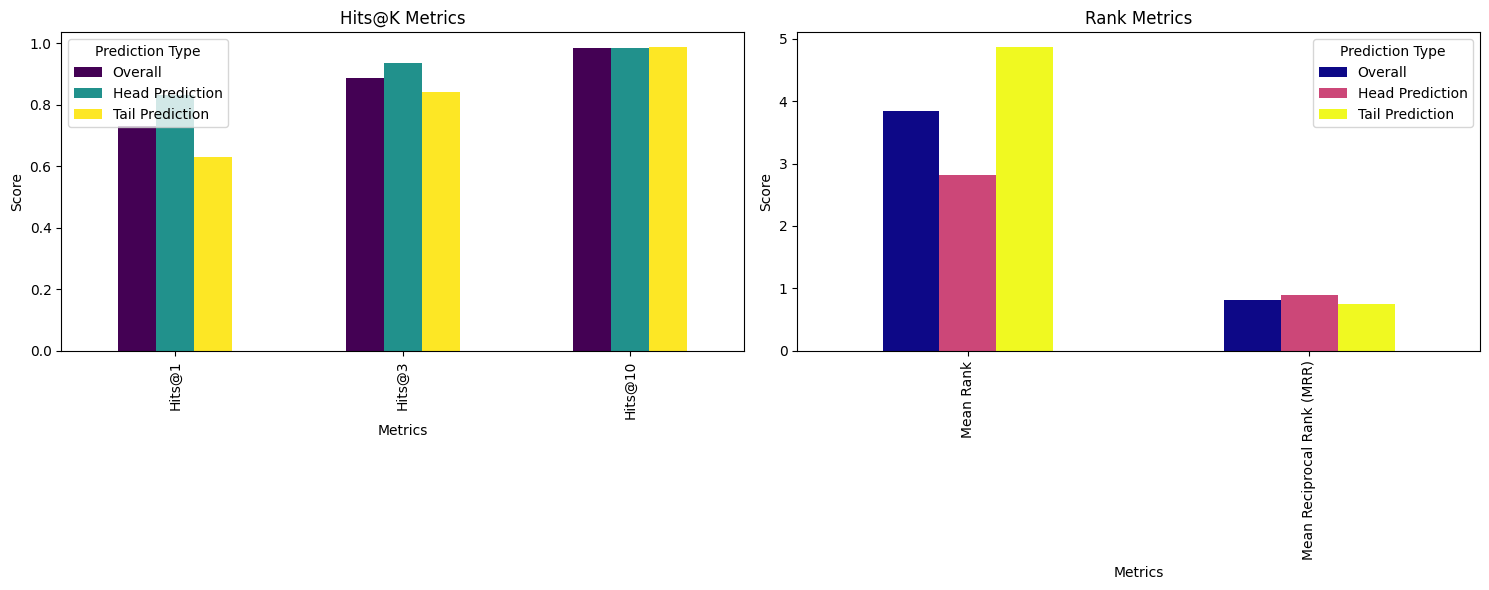

In [72]:
# Plot the metrics
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Bar Plot for Hits@K Metrics
hits_metrics = metrics_df[metrics_df['Metric'].str.startswith("Hits")]
hits_metrics.plot(x="Metric", kind="bar", ax=ax[0], colormap="viridis")
ax[0].set_title("Hits@K Metrics")
ax[0].set_ylabel("Score")
ax[0].set_xlabel("Metrics")
ax[0].legend(title="Prediction Type")

# Bar Plot for Rank Metrics
rank_metrics = metrics_df[~metrics_df['Metric'].str.startswith("Hits")]
rank_metrics.plot(x="Metric", kind="bar", ax=ax[1], colormap="plasma")
ax[1].set_title("Rank Metrics")
ax[1].set_ylabel("Score")
ax[1].set_xlabel("Metrics")
ax[1].legend(title="Prediction Type")

plt.tight_layout()
plt.show()

In [35]:
# Train ComplEx model
complex_result = pipeline(
    model='ComplEx',
    training=training_factory,
    validation=validation_factory,
    testing=testing_factory,
    epochs=10,
    dimensions=128,
    negative_sampler='basic',
    negative_sampler_kwargs={'num_negs_per_pos': 50},  # Increase negatives if needed
    training_kwargs={
        'checkpoint_name': 'complex_checkpoint.pt',  # File to save checkpoints
        'checkpoint_frequency': 3,  # Save every 3 epochs
    },
    random_seed=42,
    evaluator_kwargs={
        'filtered': True
    }
)


INFO:pykeen.pipeline.api:=> no training loop checkpoint file found at '/Users/pratistha99/.data/pykeen/checkpoints/complex_checkpoint.pt'. Creating a new file.
INFO:pykeen.pipeline.api:Using device: None
INFO:pykeen.training.training_loop:=> no checkpoint found at '/Users/pratistha99/.data/pykeen/checkpoints/complex_checkpoint.pt'. Creating a new file.
Training batches on cpu: 100%|██████████████████████▉| 654/655 [00:44<00:00, 15.44batch/s]
Training epochs on cpu:  20%|▏| 2/10 [01:27<05:52, 44.03s/epoch, loss=7.84, prev_loss=13.2
Training batches on cpu: 100%|██████████████████████▉| 654/655 [00:45<00:00, 14.25batch/s]
Training epochs on cpu:  30%|▎| 3/10 [02:14<05:20, 45.78s/epoch, loss=3.97, prev_loss=7.84
Training batches on cpu: 100%|███████████████████████| 655/655 [00:50<00:00, 13.21batch/s]
Training epochs on cpu:  30%|▎| 3/10 [03:08<05:20, 45.78s/epoch, loss=1.58, prev_loss=3.97INFO:pykeen.training.training_loop:=> Saved checkpoint after having finished epoch 4.
Training epoch

In [36]:
# Save the model to a directory
output_directory = "trained_complex_result"
complex_result.save_to_directory(output_directory)

INFO:pykeen.triples.triples_factory:Stored TriplesFactory(num_entities=1575, num_relations=2, create_inverse_triples=False, num_triples=167650) to file:///Users/pratistha99/Desktop/BDMA/CS/subjects/BDRP/trained_complex_result/training_triples
INFO:pykeen.pipeline.api:Saved to directory: /Users/pratistha99/Desktop/BDMA/CS/subjects/BDRP/trained_complex_result


In [73]:
import json
import pandas as pd

# Path to the results JSON file
results_path = "trained_complex_result/results.json"

# Load the results file
with open(results_path, "r") as f:
    results = json.load(f)

# Extract the metrics
metrics = results.get("metrics", {})
realistic = metrics.get("both", {}).get("realistic", {})
head_realistic = metrics.get("head", {}).get("realistic", {})
tail_realistic = metrics.get("tail", {}).get("realistic", {})

# Combine the metrics into a DataFrame for better readability
performance_data = {
    "Metric": [
        "Mean Rank",
        "Mean Reciprocal Rank (MRR)",
        "Hits@1",
        "Hits@3",
        "Hits@10",
    ],
    "Overall": [
        realistic.get("arithmetic_mean_rank", None),
        realistic.get("inverse_harmonic_mean_rank", None),
        realistic.get("hits_at_1", None),
        realistic.get("hits_at_3", None),
        realistic.get("hits_at_10", None),
    ],
    "Head Prediction": [
        head_realistic.get("arithmetic_mean_rank", None),
        head_realistic.get("inverse_harmonic_mean_rank", None),
        head_realistic.get("hits_at_1", None),
        head_realistic.get("hits_at_3", None),
        head_realistic.get("hits_at_10", None),
    ],
    "Tail Prediction": [
        tail_realistic.get("arithmetic_mean_rank", None),
        tail_realistic.get("inverse_harmonic_mean_rank", None),
        tail_realistic.get("hits_at_1", None),
        tail_realistic.get("hits_at_3", None),
        tail_realistic.get("hits_at_10", None),
    ],
}

# Create a DataFrame
metrics_df = pd.DataFrame(performance_data)

# Display the metrics
print("Link Prediction Performance Metrics:")
print(metrics_df)


Link Prediction Performance Metrics:
                       Metric    Overall  Head Prediction  Tail Prediction
0                   Mean Rank  22.714460        37.467640         7.961280
1  Mean Reciprocal Rank (MRR)   0.558225         0.578283         0.538166
2                      Hits@1   0.404134         0.483340         0.324927
3                      Hits@3   0.652095         0.627697         0.676493
4                     Hits@10   0.866667         0.761475         0.971858


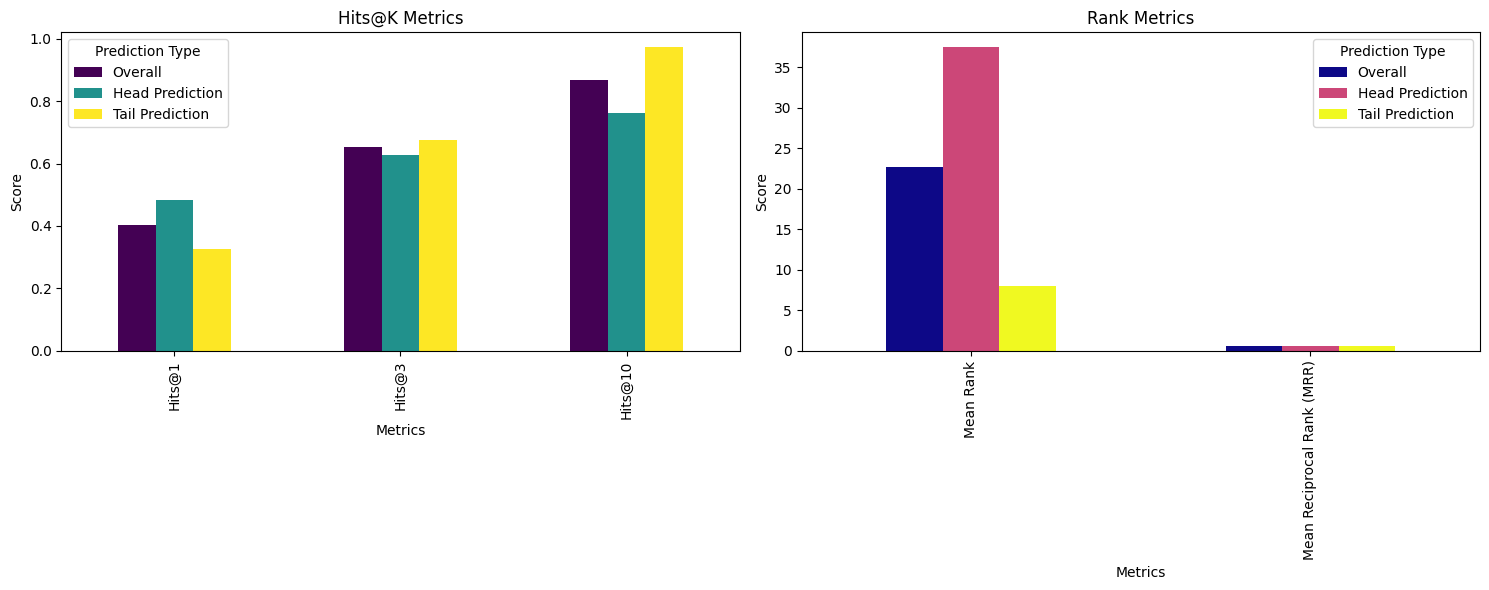

In [74]:
# Plot the metrics
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Bar Plot for Hits@K Metrics
hits_metrics = metrics_df[metrics_df['Metric'].str.startswith("Hits")]
hits_metrics.plot(x="Metric", kind="bar", ax=ax[0], colormap="viridis")
ax[0].set_title("Hits@K Metrics")
ax[0].set_ylabel("Score")
ax[0].set_xlabel("Metrics")
ax[0].legend(title="Prediction Type")

# Bar Plot for Rank Metrics
rank_metrics = metrics_df[~metrics_df['Metric'].str.startswith("Hits")]
rank_metrics.plot(x="Metric", kind="bar", ax=ax[1], colormap="plasma")
ax[1].set_title("Rank Metrics")
ax[1].set_ylabel("Score")
ax[1].set_xlabel("Metrics")
ax[1].legend(title="Prediction Type")

plt.tight_layout()
plt.show()

In [ ]:
# from pykeen.pipeline import Result

# # Load the trained model from the directory
# output_directory = "trained_complex_result"
# loaded_result_complex = Result.from_directory(output_directory)

# # Access the model
# loaded_model_complex = loaded_result.model

# print("Model successfully loaded.")


In [38]:

# Train RotatE model
rotate_result = pipeline(
    model='RotatE',
    training=training_factory,
    validation=validation_factory,
    testing=testing_factory,
    epochs=10,
    dimensions=128,
    negative_sampler='basic',
    negative_sampler_kwargs={'num_negs_per_pos': 50},  # Increase negatives if needed
    training_kwargs={
        'checkpoint_name': 'rotate_checkpoint.pt',  # File to save checkpoints
        'checkpoint_frequency': 3,  # Save every 3 epochs
    },
    random_seed=42,
    evaluator_kwargs={
        'filtered': True
    }
)


INFO:pykeen.pipeline.api:=> no training loop checkpoint file found at '/Users/pratistha99/.data/pykeen/checkpoints/rotate_checkpoint.pt'. Creating a new file.
INFO:pykeen.pipeline.api:Using device: None
INFO:pykeen.training.training_loop:=> no checkpoint found at '/Users/pratistha99/.data/pykeen/checkpoints/rotate_checkpoint.pt'. Creating a new file.
Training batches on cpu: 100%|██████████████████████▉| 654/655 [00:22<00:00, 32.38batch/s]
Training epochs on cpu:  10%| | 1/10 [00:25<03:46, 25.20s/epoch, loss=0.696, prev_loss=nan
Training batches on cpu: 100%|██████████████████████▉| 653/655 [00:21<00:00, 31.16batch/s]
Training epochs on cpu:  20%|▏| 2/10 [00:48<03:12, 24.07s/epoch, loss=0.493, prev_loss=0.6
Training batches on cpu: 100%|██████████████████████▉| 654/655 [00:22<00:00, 29.13batch/s]
Training epochs on cpu:  30%|▎| 3/10 [01:12<02:49, 24.20s/epoch, loss=0.464, prev_loss=0.4
Training batches on cpu: 100%|██████████████████████▉| 653/655 [00:23<00:00, 27.08batch/s]
Training e

In [75]:
# # Print evaluation metrics
# print("Evaluation Metrics:")
# print(rotate_result.metric_results.to_df())

In [ ]:
# Save the model to a directory
output_directory = "trained_rotate_result"
complex_result.save_to_directory(output_directory)

In [ ]:

# Extract embeddings from models
transE_embeddings = transe_result.model.entity_representations[0]().detach().cpu().numpy()
complEx_embeddings = np.concatenate(
    [complex_result.model.entity_representations[0]().real.detach().cpu().numpy(),
     complex_result.model.entity_representations[0]().imag.detach().cpu().numpy()],
    axis=1
)
rotate_embeddings = rotate_result.model.entity_representations[0]().detach().cpu().numpy()

In [ ]:
# Convert RotatE complex embeddings to real-valued embeddings
rotate_real_embeddings = np.concatenate(
    [rotate_embeddings.real, rotate_embeddings.imag], axis=1
)


In [76]:
import json
import pandas as pd

# Path to the results JSON file
results_path = "trained_rotate_result/results.json"

# Load the results file
with open(results_path, "r") as f:
    results = json.load(f)

# Extract the metrics
metrics = results.get("metrics", {})
realistic = metrics.get("both", {}).get("realistic", {})
head_realistic = metrics.get("head", {}).get("realistic", {})
tail_realistic = metrics.get("tail", {}).get("realistic", {})

# Combine the metrics into a DataFrame for better readability
performance_data = {
    "Metric": [
        "Mean Rank",
        "Mean Reciprocal Rank (MRR)",
        "Hits@1",
        "Hits@3",
        "Hits@10",
    ],
    "Overall": [
        realistic.get("arithmetic_mean_rank", None),
        realistic.get("inverse_harmonic_mean_rank", None),
        realistic.get("hits_at_1", None),
        realistic.get("hits_at_3", None),
        realistic.get("hits_at_10", None),
    ],
    "Head Prediction": [
        head_realistic.get("arithmetic_mean_rank", None),
        head_realistic.get("inverse_harmonic_mean_rank", None),
        head_realistic.get("hits_at_1", None),
        head_realistic.get("hits_at_3", None),
        head_realistic.get("hits_at_10", None),
    ],
    "Tail Prediction": [
        tail_realistic.get("arithmetic_mean_rank", None),
        tail_realistic.get("inverse_harmonic_mean_rank", None),
        tail_realistic.get("hits_at_1", None),
        tail_realistic.get("hits_at_3", None),
        tail_realistic.get("hits_at_10", None),
    ],
}

# Create a DataFrame
metrics_df = pd.DataFrame(performance_data)

# Display the metrics
print("Link Prediction Performance Metrics:")
print(metrics_df)


Link Prediction Performance Metrics:
                       Metric   Overall  Head Prediction  Tail Prediction
0                   Mean Rank  4.732185         2.256534         7.207836
1  Mean Reciprocal Rank (MRR)  0.845890         0.892954         0.798827
2                      Hits@1  0.769144         0.836632         0.701656
3                      Hits@3  0.905692         0.941211         0.870174
4                     Hits@10  0.986013         0.984384         0.987641


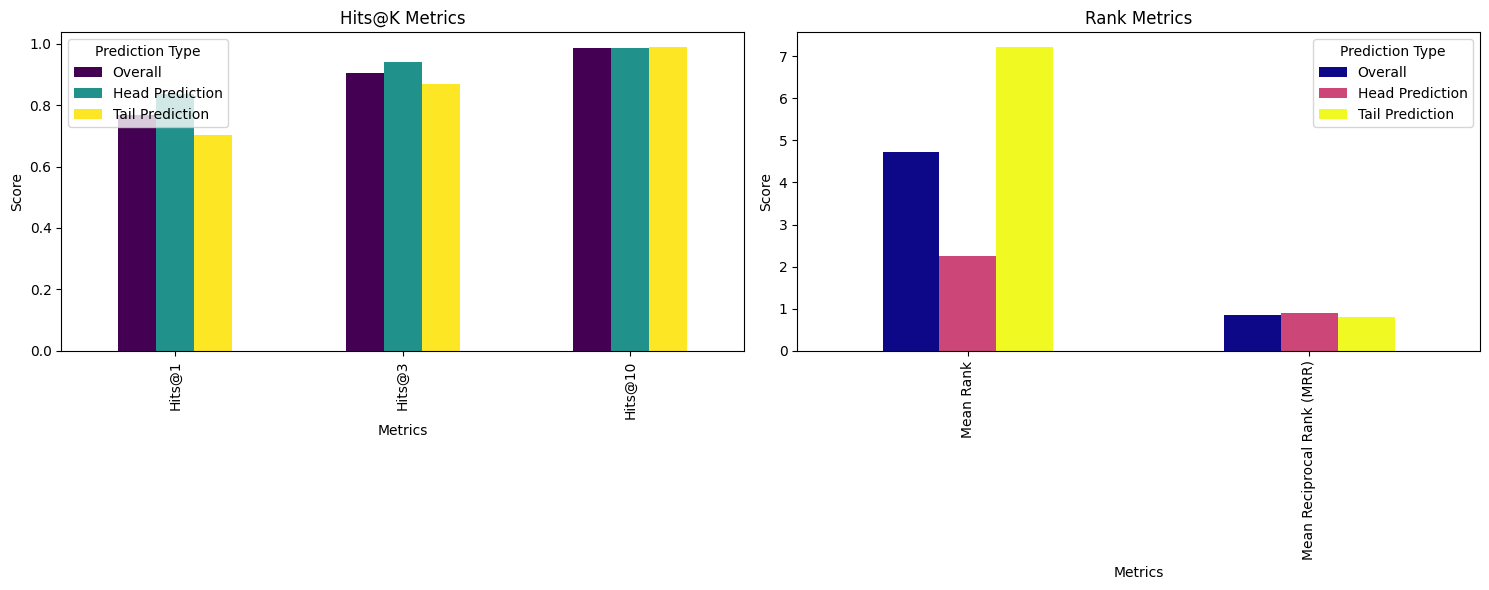

In [77]:
# Plot the metrics
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

# Bar Plot for Hits@K Metrics
hits_metrics = metrics_df[metrics_df['Metric'].str.startswith("Hits")]
hits_metrics.plot(x="Metric", kind="bar", ax=ax[0], colormap="viridis")
ax[0].set_title("Hits@K Metrics")
ax[0].set_ylabel("Score")
ax[0].set_xlabel("Metrics")
ax[0].legend(title="Prediction Type")

# Bar Plot for Rank Metrics
rank_metrics = metrics_df[~metrics_df['Metric'].str.startswith("Hits")]
rank_metrics.plot(x="Metric", kind="bar", ax=ax[1], colormap="plasma")
ax[1].set_title("Rank Metrics")
ax[1].set_ylabel("Score")
ax[1].set_xlabel("Metrics")
ax[1].legend(title="Prediction Type")

plt.tight_layout()
plt.show()

In [32]:
# np.save("entity_embeddings.npy", entity_embeddings)
# np.save("relation_embeddings.npy", relation_embeddings)

# print("Embeddings saved successfully.")

In [33]:
# entity_embeddings = np.load("entity_embeddings.npy")
# relation_embeddings = np.load("relation_embeddings.npy")


In [44]:
import torch
from torch_geometric.data import Data
from torch_geometric.nn import GCNConv

# Prepare the graph data
# Define entity IDs
entities = {entity: idx for idx, entity in enumerate(training_factory.entity_to_id.keys())}

# Convert triples into edges for PyTorch Geometric
edge_index = torch.tensor([
    [entities[head], entities[tail]]
    for head, _, tail in training_factory.triples
]).t().contiguous()

# Create a graph
num_nodes = len(entities)
x = torch.randn(num_nodes, 128)  # Random initialization of node features
data = Data(x=x, edge_index=edge_index)

# Define GCN Model
class GCNModel(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = self.conv1(x, edge_index)
        x = torch.relu(x)
        x = self.conv2(x, edge_index)
        return x

# Train GCN
gcn_model = GCNModel(input_dim=128, hidden_dim=64, output_dim=128)
optimizer = torch.optim.Adam(gcn_model.parameters(), lr=0.01)
for epoch in range(50):
    optimizer.zero_grad()
    embeddings = gcn_model(data)
    loss = torch.nn.MSELoss()(embeddings, data.x)  # Reconstruction loss
    loss.backward()
    optimizer.step()

# Extract GCN embeddings
gcn_embeddings = embeddings.detach().cpu().numpy()


TransE Clustering Metrics:
Silhouette Score: 0.0229
Davies-Bouldin Index: 5.4409
Calinski-Harabasz Index: 27.2773



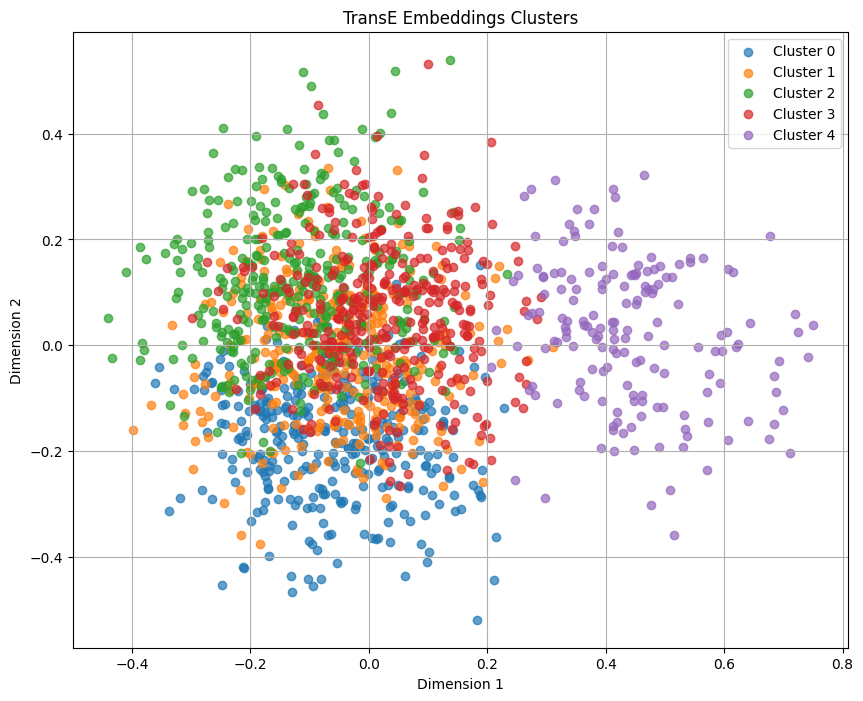

ComplEx Clustering Metrics:
Silhouette Score: 0.0010
Davies-Bouldin Index: 12.3924
Calinski-Harabasz Index: 5.1552



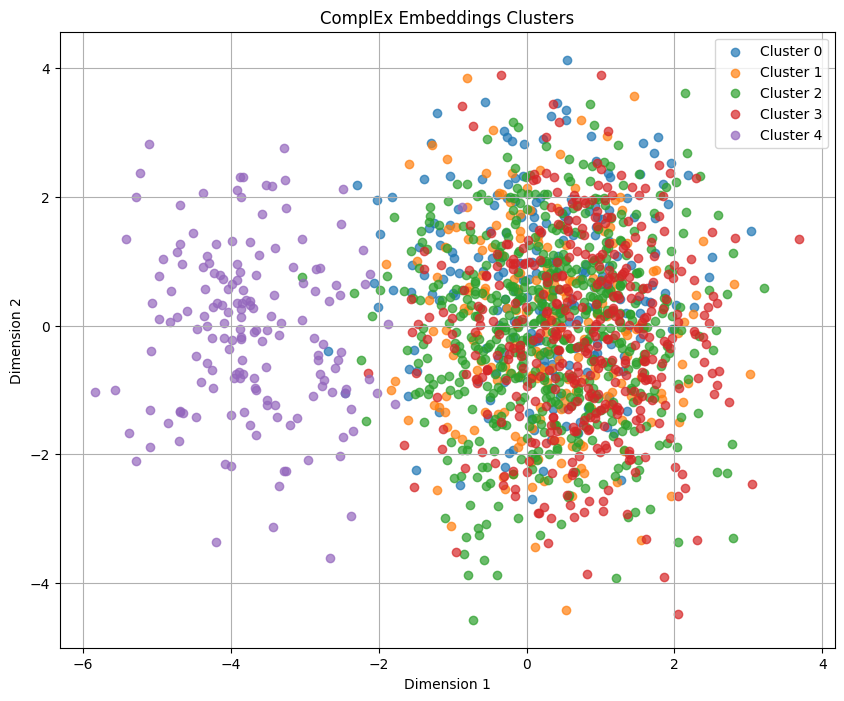

GCN Clustering Metrics:
Silhouette Score: -0.0055
Davies-Bouldin Index: 3.5439
Calinski-Harabasz Index: 53.5788



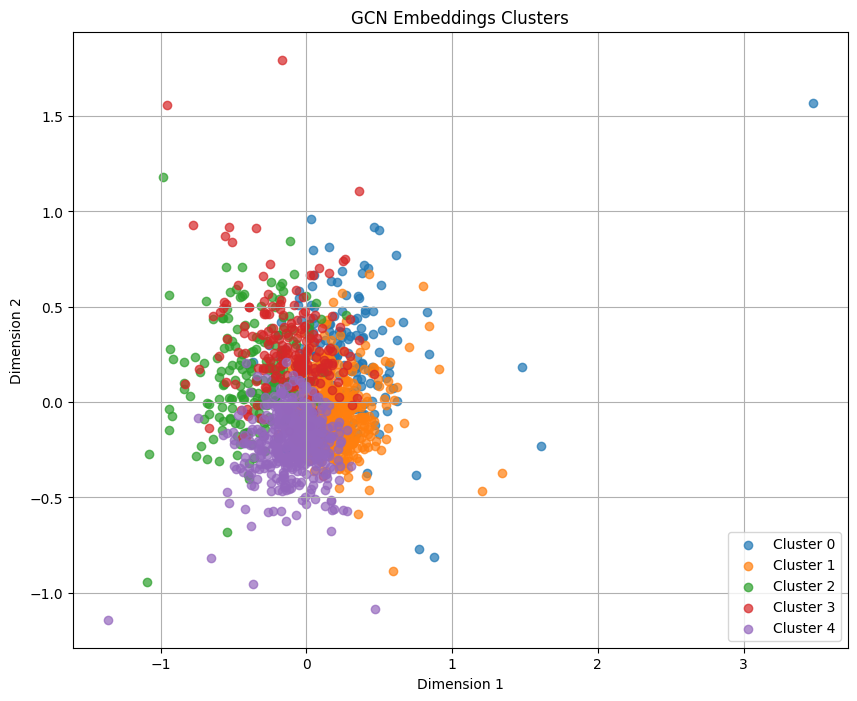

RotatE Clustering Metrics:
Silhouette Score: 0.1319
Davies-Bouldin Index: 3.1249
Calinski-Harabasz Index: 90.0370



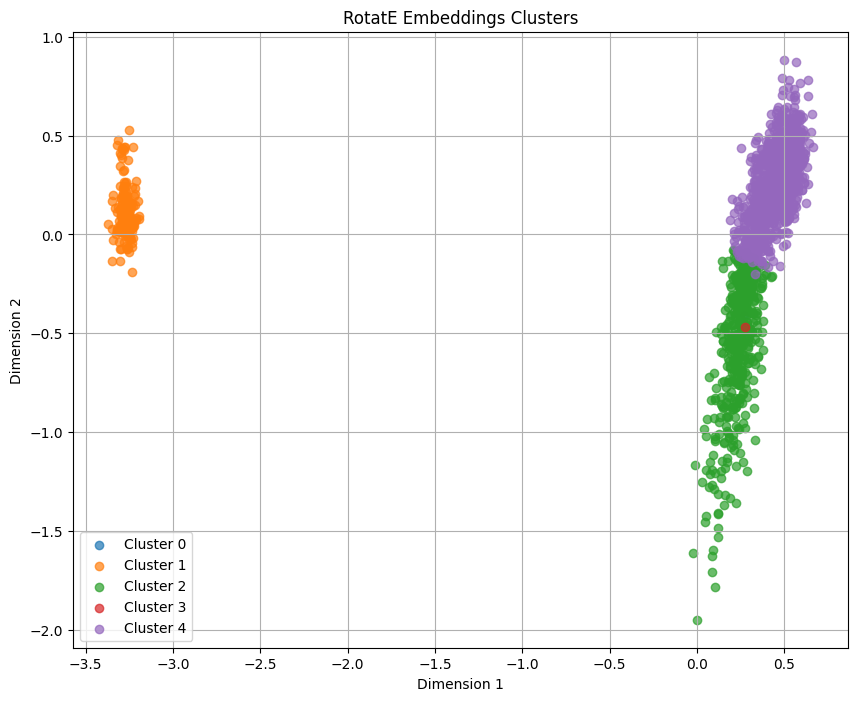

In [45]:
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score

def cluster_and_visualize(embeddings, model_name):
    # Clustering
    kmeans = KMeans(n_clusters=5, random_state=42)
    cluster_labels = kmeans.fit_predict(embeddings)

    # Calculate Clustering Metrics
    silhouette = silhouette_score(embeddings, cluster_labels)
    db_index = davies_bouldin_score(embeddings, cluster_labels)
    ch_index = calinski_harabasz_score(embeddings, cluster_labels)

    print(f"{model_name} Clustering Metrics:")
    print(f"Silhouette Score: {silhouette:.4f}")
    print(f"Davies-Bouldin Index: {db_index:.4f}")
    print(f"Calinski-Harabasz Index: {ch_index:.4f}\n")

    # Dimensionality Reduction (PCA)
    reduced_embeddings = PCA(n_components=2).fit_transform(embeddings)

    # Visualization
    plt.figure(figsize=(10, 8))
    for cluster_id in np.unique(cluster_labels):
        cluster_entities = clusters_df[clusters_df['cluster'] == cluster_id]['entity']
        print(f"Cluster {cluster_id} contains {len(cluster_entities)} entities")
        print(cluster_entities.head())
        cluster_points = reduced_embeddings[cluster_labels == cluster_id]
        plt.scatter(cluster_points[:, 0], cluster_points[:, 1], label=f"Cluster {cluster_id}", alpha=0.7)
    plt.title(f"{model_name} Embeddings Clusters")
    plt.xlabel("Dimension 1")
    plt.ylabel("Dimension 2")
    plt.legend()
    plt.grid()
    plt.show()

# Apply clustering and visualization for each embedding type
cluster_and_visualize(transE_embeddings, "TransE")
cluster_and_visualize(complEx_embeddings, "ComplEx")
cluster_and_visualize(gcn_embeddings, "GCN")
cluster_and_visualize(rotate_real_embeddings, "RotatE")



# Interpretation of Clustering Metrics for Derived and Original Relationships

## Clustering Metrics Recap

**Silhouette Score**
- Measures similarity of object to its cluster vs other clusters
- Range: [-1, 1]
- Higher values = better cluster separation and cohesion
- Negative values indicate poor clustering

**Davies-Bouldin Index**
- Measures ratio of intra-cluster to inter-cluster distances
- Lower values are better (compact, well-separated clusters)

**Calinski-Harabasz Index**
- Measures ratio of between-cluster to within-cluster dispersion
- Higher values are better (dense, well-separated clusters)

## Results Overview

### 1. Derived Relationships (hasExpressionHigh, isAssociatedWithPathway, hasSample)

| Model   | Silhouette | DB Index | CH Index |
|---------|------------|----------|----------|
| TransE  | 0.0229     | 5.4409   | 27.2773  |
| ComplEx | 0.0010     | 12.3924  | 5.1552   |
| GCN     | -0.0055    | 3.5439   | 53.5788  |
| RotatE  | 0.1319     | 3.1249   | 90.0370  |

### 2. Original Relationships (hasSample, isAssociatedWithPathway, hasGeneExpression)

| Model   | Silhouette | DB Index | CH Index |
|---------|------------|----------|----------|
| TransE  | 0.0235     | 5.3569   | 52.1089  |
| ComplEx | 0.0001     | 12.3672  | 4.1228   |
| GCN     | 0.8374     | 0.5031   | 546.9454 |
| RotatE  | 0.0434     | 3.2702   | 211.2308 |

## Detailed Analysis

### 1. TransE

**Derived Relationships:**
- Silhouette Score: 0.0229 – indicates very weak clustering cohesion and separation
- Davies-Bouldin Index: 5.4409 – relatively high, suggesting clusters are not compact and overlap significantly
- Calinski-Harabasz Index: 27.2773 – moderate, suggesting clusters are dispersed

**Original Relationships:**
- Silhouette Score: 0.0235 – slightly better, but still poor clustering quality
- Davies-Bouldin Index: 5.3569 – a marginal improvement in cluster compactness and separation
- Calinski-Harabasz Index: 52.1089 – significant improvement in between-cluster dispersion

**Intuition:** TransE performs better on the original relationships, as evidenced by the improved CH Index. This suggests that the original relationships provide richer structural information for the embedding model.

### 2. ComplEx

**Derived Relationships:**
- Silhouette Score: 0.0010 – almost zero, indicating random or poor clustering
- Davies-Bouldin Index: 12.3924 – extremely high, suggesting significant overlap between clusters
- Calinski-Harabasz Index: 5.1552 – very low, indicating poor cluster density and separation

**Original Relationships:**
- Silhouette Score: 0.0001 – almost the same, extremely poor clustering
- Davies-Bouldin Index: 12.3672 – slightly improved but still poor compactness
- Calinski-Harabasz Index: 4.1228 – very low

**Intuition:** ComplEx struggles with both derived and original relationships. The metrics suggest that the embeddings do not capture meaningful separations in the data.

### 3. GCN (Graph Convolutional Network)

**Derived Relationships:**
- Silhouette Score: -0.0055 – negative score indicates wrong cluster assignments
- Davies-Bouldin Index: 3.5439 – moderate, but shows poor separation between clusters
- Calinski-Harabasz Index: 53.5788 – suggests some structure but still suboptimal

**Original Relationships:**
- Silhouette Score: 0.8374 – exceptionally high, indicating well-separated and cohesive clusters
- Davies-Bouldin Index: 0.5031 – very low, meaning compact and well-separated clusters
- Calinski-Harabasz Index: 546.9454 – extremely high, indicating excellent clustering performance

**Intuition:** GCN excels with original relationships, as evidenced by the drastic improvement in all clustering metrics. Derived relationships likely lose fine-grained structure required for effective topology capture.

### 4. RotatE

**Derived Relationships:**
- Silhouette Score: 0.1319 – highest among derived relationships
- Davies-Bouldin Index: 3.1249 – suggests acceptable cluster separation
- Calinski-Harabasz Index: 90.0370 – moderate performance

**Original Relationships:**
- Silhouette Score: 0.0434 – lower than derived relationships
- Davies-Bouldin Index: 3.2702 – slightly worse than derived relationships
- Calinski-Harabasz Index: 211.2308 – significantly better cluster dispersion

**Intuition:** RotatE performs reasonably well on both relationship types, showing more robustness compared to TransE and ComplEx.

## Key Insights

- GCN shows the best clustering performance on original relationships
- RotatE performs moderately well on both relationship types
- TransE and ComplEx perform poorly overall
- Derived relationships may oversimplify the data structure

## Recommendations

- Use original relationships for models like GCN and RotatE
- Consider derived relationships only when simplification is required
- Prioritize GCN and RotatE when working with simplified relationships


# Link Prediction Performance Interpretation

## Model Performance Analysis

### RotatE Model

| Metric | Overall | Head Prediction | Tail Prediction |
|--------|---------|-----------------|-----------------|
| Mean Rank | 4.73 | 2.26 | 7.21 |
| MRR | 0.8459 | 0.8930 | 0.7988 |
| Hits@1 | 0.7691 | 0.8366 | 0.7017 |
| Hits@3 | 0.9057 | 0.9412 | 0.8702 |
| Hits@10 | 0.9860 | 0.9844 | 0.9876 |

**Key Findings:**
- Achieves low mean rank (4.73), indicating high-accuracy predictions
- Strong head prediction performance (MR: 2.26) compared to tail prediction (MR: 7.21)
- High MRR of 0.8459 shows consistent top-ranking performance
- Excellent Hits@10 score of 98.60% demonstrates robust overall accuracy

### TransE Model

| Metric | Overall | Head Prediction | Tail Prediction |
|--------|---------|-----------------|-----------------|
| Mean Rank | 3.83 | 2.81 | 4.86 |
| MRR | 0.8207 | 0.8887 | 0.7526 |
| Hits@1 | 0.7311 | 0.8310 | 0.6312 |
| Hits@3 | 0.8891 | 0.9371 | 0.8410 |
| Hits@10 | 0.9858 | 0.9847 | 0.9869 |

**Key Findings:**
- Very low mean rank (3.83) indicates precise predictions
- Smaller gap between head (2.81) and tail (4.86) prediction performance
- Strong MRR of 0.8207 shows reliable ranking capability
- High Hits@10 score of 98.58% matches RotatE's performance

### ComplEx Model

| Metric | Overall | Head Prediction | Tail Prediction |
|--------|---------|-----------------|-----------------|
| Mean Rank | 22.71 | 37.47 | 7.96 |
| MRR | 0.5582 | 0.5783 | 0.5382 |
| Hits@1 | 0.4041 | 0.4833 | 0.3249 |
| Hits@3 | 0.6521 | 0.6277 | 0.6765 |
| Hits@10 | 0.8667 | 0.7615 | 0.9719 |

**Key Findings:**
- Higher mean rank (22.71) suggests lower prediction accuracy
- Significant disparity between head (37.47) and tail (7.96) predictions
- Moderate MRR of 0.5582 indicates room for improvement
- Lower Hits@1 (40.41%) compared to other models

## Comparative Analysis

**Model Ranking (Overall Performance):**
1. RotatE: Best overall performance with highest MRR and consistent Hits@K scores
2. TransE: Close second with slightly lower but competitive metrics
3. ComplEx: Shows significantly lower performance across all metrics

**Head vs Tail Prediction:**
- RotatE and TransE excel in head prediction
- ComplEx shows better performance in tail prediction
- All models show some asymmetry between head and tail prediction capabilities

## Recommendations

- Consider RotatE for applications requiring high precision
- Use TransE as a reliable baseline model
- ComplEx may benefit from:
  - Additional training epochs
  - Hyperparameter optimization
  - Architecture modifications
